# MIS 583 Assignment 4: Self-supervised and transfer learning on CIFAR10

張梓揚, M114030007  

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

###:rotate_img  函數 作圖圖片旋轉
def rotate_img(img, rot):
    if rot == 0:   # 0 degrees rotation (沒有旋轉)
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img
    elif rot == 1:  # 90 degrees rotation
        return torch.rot90(img, k=1, dims=(1, 2)) #k=1表示逆時針轉90度  dims=(1, 2) 表示在第1個維度（高度）和第2個維度（寬度）上進行旋轉
    elif rot == 2:  # 180 degrees rotation
        return torch.rot90(img, k=2, dims=(1, 2))
    elif rot == 3:  # 270 degrees rotation
        return torch.rot90(img, k=3, dims=(1, 2))
    #######################################################################
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10): #繼承自 torchvision.datasets.CIFAR10  含了旋轉過的圖片和相應的標籤。這可以用於訓練模型，使其對於不同旋轉角度的圖片具（robustness）

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int): #除了返回原始圖片和標籤之外，還返回了經過隨機旋轉的圖片以及相應的旋轉標籤
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label) #呼叫了之前定義的 rotate_img 函數，將原始圖片 image 旋轉到指定的角度，得到 image_rotated

        rotation_label = torch.tensor(rotation_label).long() #將旋轉標籤轉換成 PyTorch 張量，並使用 .long() 方法確保數據類型是整數。
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long() #返回一個tuple，包含原始圖片、旋轉後的圖片、旋轉標籤和原始的類別標籤


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

100%|██████████| 170498071/170498071 [00:13<00:00, 12959722.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Show some example images and rotated images with labels:

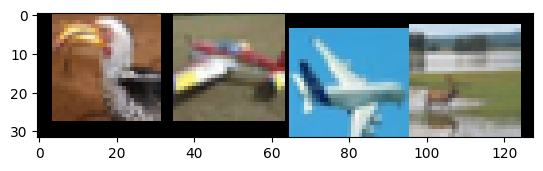

Class labels:  bird  plane plane deer 


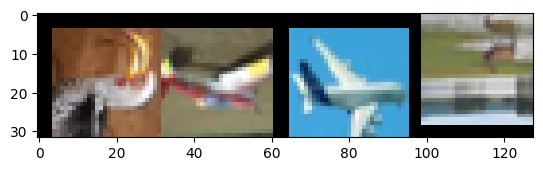

Rotation labels:  270   180   0     180  


In [ ]:
#CIFAR-10包含60000張 32 × 32 的彩色圖片(10000張是test 50000萬張是train的樣子)，每張圖片裡面都包含有一個物件，這個物件屬於 10 個類別中的其中一個類別。test中每個類別各有 1000 張圖片


import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)   #作反標準化處理 還原原始數據的範圍
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)    #在作一次正規化處理
    npimg = img.numpy() #Matplotlib的imshow函數通常接受NumPy數組作為輸入
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()  #np.transpose將數組的軸重新排列，以符合Matplotlib對數據的預期格式


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter) #next函數從迭代器中獲取一個batch的數據。這個batch包括了原始圖像(images)、旋轉後的圖像(rot_images)、對應的旋轉標籤(rot_labels)以及物體類別標籤(labels)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
#使用torchvision.utils.make_grid函數將原始圖像的前4張合併成一個網格，然後使用前面定義的imshow函數顯示這個網格。同時，使用列表推導式和join函數，將這4張圖像對應的物體類別標籤印出
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
#這裡將旋轉後的圖像的前4張合併成一個網格，並使用imshow函數顯示。同時，使用列表推導式和join函數，將這4張圖像對應的旋轉標籤印出
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

評估神經網絡在測試集上的準確性和平均損失

In [4]:
import time
def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)

            # The class with the highest score is what we choose as our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [5]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
#簡單來說就是每30圈後 lr都會遞減

# 1.Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

from scratch 從0開始
rotation task

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [ ]:
#把還沒訓練過的resnet架構丟進來
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.  因為如果pre-trained直接把weight丟進來就好  #num_classes=4 0 1 2 3
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # criterion = nn.CrossEntropyLoss()  可以兩個都試試看  label_smoothing看作業4筆記
optimizer = optim.Adam(net.parameters(), lr=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)


#label smoothing 常用在分類網路中來防止過擬和的一種方法，整體簡單易用，在小資料集上可以取得非常好的效果

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train() #將模型設置為訓練模式，啟用 Batch Normalization 和 Dropout

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  !!!!!!!!這段很重要 不同task要分開看!
            if task == 'rotation':
              imgs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              imgs, labels = imgs.to(device), cls_label.to(device)
            else:
              raise ValueError(f"Unsupported task: {task}")
            # TODO: Zero the parameter gradients                                                                 #
            optimizer.zero_grad()

            # TODO: forward + backward + optimize                                                                #
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results                                                                        #
            _, predicted = torch.max(outputs.data, 1)                                                                      #
            ######################################################################################################

            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()  # Set the model to the evaluation mode
        run_test(net, testloader, criterion, task)
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #
################################
#torch.save(net.state_dict(), 'rotation_model_1.pth')  # 保存模型權重
################################
#      End of your code        #
################################
#[1, 100] loss: 1.597 acc: 29.38 time: 11.34：在第一个 epoch 中，训练的前100个小批次的平均损失为1.597，准确率为29.38% (batchsize是128)
#[1, 200] loss: 1.314 acc: 41.97 time: 9.01：在第一个 epoch 中，训练的101到200个小批次的平均损失为1.314，准确率为41.97%，训练时间为9.01秒
#[1, 300] loss: 1.261 acc: 45.77 time: 10.00：在第一个 epoch 中，训练的201到300个小批次的平均损失为1.261，准确率为45.77%，训练时间为10.00秒。
#TESTING: Accuracy of the network on the 10000 test images: 52.34 % Average loss on the 10000 test images: 1.156：在第一个 epoch 结束后，进行测试集上的评估，模型在测试集上的准确率为52.34%，平均损失为1.156。
#沒記錯的話 test1萬張 train4萬張

[1,   100] loss: 1.597 acc: 29.38 time: 11.34
[1,   200] loss: 1.314 acc: 41.97 time: 9.01
[1,   300] loss: 1.261 acc: 45.77 time: 10.00
TESTING:
Accuracy of the network on the 10000 test images: 52.34 %
Average loss on the 10000 test images: 1.156
[2,   100] loss: 1.187 acc: 49.75 time: 9.49
[2,   200] loss: 1.163 acc: 51.77 time: 8.99
[2,   300] loss: 1.144 acc: 52.84 time: 9.03
TESTING:
Accuracy of the network on the 10000 test images: 51.14 %
Average loss on the 10000 test images: 1.183
[3,   100] loss: 1.130 acc: 54.21 time: 9.41
[3,   200] loss: 1.120 acc: 54.78 time: 8.50
[3,   300] loss: 1.110 acc: 56.12 time: 9.26
TESTING:
Accuracy of the network on the 10000 test images: 56.28 %
Average loss on the 10000 test images: 1.123
[4,   100] loss: 1.088 acc: 57.52 time: 9.53
[4,   200] loss: 1.082 acc: 57.60 time: 8.27
[4,   300] loss: 1.077 acc: 57.98 time: 9.25
TESTING:
Accuracy of the network on the 10000 test images: 59.40 %
Average loss on the 10000 test images: 1.054
[5,   100]

In [ ]:
import os
os.chdir('/content/drive/My Drive')
#torch.save(net.state_dict(), 'rotation_model1.pth')

## 2.Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
ckpt = torch.load('rotation_model1.pth')
net.load_state_dict(ckpt)
print(net) # print your model and check the num_classes is correct  沒錯四類 0123  (沒轉 轉90 轉180 轉270)
####################################################
#                End of your code                  #
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     ##這樣就只有layer4和 fc'層的参数的 requires_grad 属性设置为 True，是可以訓練的  騎他都被凍結了
#################################################################################################
# Freeze all parameters
for param in net.parameters():
    param.requires_grad = False

# Adjusting the fully connected layer to have 10 outputs for 10 classes   #這行他在原本需求裡面沒有說清楚 因為本來是旋轉只會輸出0123 等等task會變成分10類 所以fc當然要改
net.fc = nn.Linear(net.fc.in_features, 10)  # Re-define the fc layer

# Unfreeze the last block (layer4) and the fully connected (fc) layer
net.layer4.requires_grad_(True)
net.fc.requires_grad_(True)

# Make sure to move the model to the device after modifying it
net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}
], lr=0.005)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.891 acc: 33.82 time: 15.81
[1,   200] loss: 1.669 acc: 44.73 time: 7.63
[1,   300] loss: 1.621 acc: 48.16 time: 7.56
TESTING:
Accuracy of the network on the 10000 test images: 50.68 %
Average loss on the 10000 test images: 1.553
[2,   100] loss: 1.560 acc: 51.05 time: 7.19
[2,   200] loss: 1.558 acc: 50.87 time: 8.00
[2,   300] loss: 1.536 acc: 52.14 time: 7.88
TESTING:
Accuracy of the network on the 10000 test images: 52.93 %
Average loss on the 10000 test images: 1.509
[3,   100] loss: 1.518 acc: 52.66 time: 8.08
[3,   200] loss: 1.514 acc: 53.47 time: 7.54
[3,   300] loss: 1.510 acc: 53.61 time: 8.63
TESTING:
Accuracy of the network on the 10000 test images: 54.35 %
Average loss on the 10000 test images: 1.484
[4,   100] loss: 1.498 acc: 53.95 time: 7.21
[4,   200] loss: 1.496 acc: 53.49 time: 8.10
[4,   300] loss: 1.496 acc: 54.30 time: 7.11
TESTING:
Accuracy of the network on the 10000 test images: 55.96 %
Average loss on the 10000 test images: 1.450
[5,   100] 

## 3.Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

第一種方法利用了先前在旋轉任務上學到的知識，而第二種方法從頭開始，不使用任何先前的知識

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
# Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
# Freeze all parameters
net.requires_grad_(False)

# Adjusting the fully connected layer to have 10 outputs for 10 classes
net.fc = nn.Linear(net.fc.in_features, 10)  # Re-define the fc layer

# Unfreeze the last block (layer4) and the fully connected (fc) layer
net.layer4.requires_grad_(True)
net.fc.requires_grad_(True)

# Make sure to move the model to the device after modifying it
net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam([
    {'params': net.layer4.parameters()},
    {'params': net.fc.parameters()}
], lr=0.005)

criterion.to(device)

CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.359 acc: 23.63 time: 7.89
[1,   200] loss: 2.054 acc: 29.39 time: 7.31
[1,   300] loss: 1.996 acc: 31.59 time: 8.07
TESTING:
Accuracy of the network on the 10000 test images: 35.71 %
Average loss on the 10000 test images: 1.895
[2,   100] loss: 1.940 acc: 33.61 time: 7.65
[2,   200] loss: 1.936 acc: 34.02 time: 7.94
[2,   300] loss: 1.928 acc: 33.38 time: 7.16
TESTING:
Accuracy of the network on the 10000 test images: 36.78 %
Average loss on the 10000 test images: 1.858
[3,   100] loss: 1.901 acc: 34.88 time: 7.56
[3,   200] loss: 1.887 acc: 35.71 time: 7.60
[3,   300] loss: 1.886 acc: 36.20 time: 8.00
TESTING:
Accuracy of the network on the 10000 test images: 38.98 %
Average loss on the 10000 test images: 1.818
[4,   100] loss: 1.873 acc: 36.86 time: 7.96
[4,   200] loss: 1.872 acc: 36.54 time: 7.67
[4,   300] loss: 1.862 acc: 36.69 time: 7.39
TESTING:
Accuracy of the network on the 10000 test images: 39.73 %
Average loss on the 10000 test images: 1.825
[5,   100] l

## 4.Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
net = resnet18(weights=None, num_classes=4) #加載ResNet18 旋轉模型的空架構  所有輸出是4種
ckpt = torch.load('rotation_model1.pth')   #載ResNet18 旋轉模型的參數
net.load_state_dict(ckpt)   #把參數包到空架構裡 就是之前訓練好的rotation模型

net.fc = nn.Linear(net.fc.in_features, 10)  #現在改一點點就好 把輸出從4改成10
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam(lr=0.001, params=net.parameters())  #這邊所有參數都要train

criterion.to(device)

CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.655 acc: 45.95 time: 18.99
[1,   200] loss: 1.408 acc: 57.84 time: 11.26
[1,   300] loss: 1.318 acc: 62.87 time: 9.96
TESTING:
Accuracy of the network on the 10000 test images: 66.84 %
Average loss on the 10000 test images: 1.242
[2,   100] loss: 1.250 acc: 66.09 time: 11.38
[2,   200] loss: 1.208 acc: 68.32 time: 10.34
[2,   300] loss: 1.195 acc: 69.24 time: 11.82
TESTING:
Accuracy of the network on the 10000 test images: 71.41 %
Average loss on the 10000 test images: 1.138
[3,   100] loss: 1.130 acc: 71.93 time: 11.16
[3,   200] loss: 1.127 acc: 71.80 time: 11.11
[3,   300] loss: 1.123 acc: 72.32 time: 13.46
TESTING:
Accuracy of the network on the 10000 test images: 73.72 %
Average loss on the 10000 test images: 1.096
[4,   100] loss: 1.089 acc: 73.76 time: 10.15
[4,   200] loss: 1.082 acc: 74.31 time: 11.12
[4,   300] loss: 1.048 acc: 75.66 time: 11.07
TESTING:
Accuracy of the network on the 10000 test images: 74.12 %
Average loss on the 10000 test images: 1.092
[

## 5.Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(weights=None, num_classes=10)
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam(lr=0.001, params=net.parameters())
criterion.to(device)

CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.278 acc: 24.05 time: 11.25
[1,   200] loss: 1.923 acc: 33.60 time: 10.93
[1,   300] loss: 1.829 acc: 38.49 time: 11.37
TESTING:
Accuracy of the network on the 10000 test images: 45.35 %
Average loss on the 10000 test images: 1.756
[2,   100] loss: 1.702 acc: 44.02 time: 10.25
[2,   200] loss: 1.617 acc: 48.40 time: 13.27
[2,   300] loss: 1.551 acc: 51.54 time: 11.27
TESTING:
Accuracy of the network on the 10000 test images: 55.31 %
Average loss on the 10000 test images: 1.494
[3,   100] loss: 1.470 acc: 55.40 time: 10.46
[3,   200] loss: 1.416 acc: 58.37 time: 11.35
[3,   300] loss: 1.379 acc: 60.09 time: 10.60
TESTING:
Accuracy of the network on the 10000 test images: 59.87 %
Average loss on the 10000 test images: 1.400
[4,   100] loss: 1.323 acc: 62.57 time: 10.80
[4,   200] loss: 1.320 acc: 63.03 time: 12.69
[4,   300] loss: 1.285 acc: 64.18 time: 10.78
TESTING:
Accuracy of the network on the 10000 test images: 63.30 %
Average loss on the 10000 test images: 1.335


# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A4.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

-1. In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.

-2. Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
-3. If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).


# Extra: Supervised training on the pre-trained model using RESNET34 RESNET50
-Does larger model get higher accuracy on the rotation prediction task than ResNet18?

-And for transfer to supervised CIFAR10 classification?


## RESNET18 on 1. Rotation task

In [ ]:
import torchvision.models as models
import torch.nn as nn

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # 因為如果pre-trained直接把weight丟進來就好  #num_classes=4 0 1 2 3
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # criterion = nn.CrossEntropyLoss()  可以兩個都試試看  label_smoothing看作業4筆記
optimizer = optim.Adam(net.parameters(), lr=0.005)
#label smoothing 常用在分類網路中來防止過擬和的一種方法，整體簡單易用，在小資料集上可以取得非常好的效果
criterion.to(device)

CrossEntropyLoss()

### 對training process修改: 要留下的是test表現最好的model 而不是跑到最後一個epoch的model 可以避免overfitting

In [ ]:
import torch
import time

def run_test(net, testloader, criterion, task, min_loss):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            avg_test_loss += criterion(outputs, labels) / len(testloader)

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

    # 比較當前平均測試損失和最小損失
    if avg_test_loss < min_loss:
        min_loss = avg_test_loss
        # 保存當前模型的權重     #也可以用accuracy最小的 當作評斷依據
        print('Best model updated!')
        torch.save(net.state_dict(), 'best_model.pth')

    # 返回更新後的最小損失
    return min_loss

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    min_loss = float('inf')  # 初始化最小損失

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            if task == 'rotation':
                imgs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                imgs, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError(f"Unsupported task: {task}")

            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)

            print_freq = 100
            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100 * running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # 在 net.eval() 之前加入
        net.eval()
        min_loss = run_test(net, testloader, criterion, task, min_loss)

    print('Finished Training')


In [ ]:
train(net, criterion, optimizer, num_epochs=40, decay_epochs=15, init_lr=0.01, task='rotation')

[1,   100] loss: 0.834 acc: 73.66 time: 14.37
[1,   200] loss: 0.851 acc: 72.77 time: 9.28
[1,   300] loss: 0.836 acc: 73.74 time: 10.65
TESTING:
Accuracy of the network on the 10000 test images: 73.62 %
Average loss on the 10000 test images: 0.835
Best model updated!
[2,   100] loss: 0.832 acc: 73.81 time: 8.69
[2,   200] loss: 0.838 acc: 72.89 time: 10.04
[2,   300] loss: 0.824 acc: 74.09 time: 12.50
TESTING:
Accuracy of the network on the 10000 test images: 74.62 %
Average loss on the 10000 test images: 0.824
Best model updated!
[3,   100] loss: 0.822 acc: 73.95 time: 10.46
[3,   200] loss: 0.820 acc: 74.31 time: 10.00
[3,   300] loss: 0.832 acc: 73.72 time: 9.64
TESTING:
Accuracy of the network on the 10000 test images: 75.32 %
Average loss on the 10000 test images: 0.801
Best model updated!
[4,   100] loss: 0.820 acc: 74.25 time: 10.42
[4,   200] loss: 0.827 acc: 74.17 time: 9.06
[4,   300] loss: 0.812 acc: 75.13 time: 10.80
TESTING:
Accuracy of the network on the 10000 test image

In [ ]:
import shutil

# 原始文件路徑
source_path = '/content/best_model.pth'

# 目標文件夾路徑
target_folder = '/content/drive/My Drive/深度學習/HW4'

# 目標文件名稱
target_name = 'res18_rotation.pth'

# 目標文件路徑
target_path = os.path.join(target_folder, target_name)

# 移動文件並更名
shutil.move(source_path, target_path)

print(f"File moved to: {target_path}")

File moved to: /content/drive/My Drive/深度學習/res18_rotation.pth


## RESNET34 on 1. Rotation task

記得把lr調到0.001才 train的起來 設0.005會如果initial不好的話 Accuracy會卡在25%上不去

In [ ]:
import torchvision.models as models
import torch.nn as nn

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet34

net = resnet34(weights = None, num_classes=4) # 因為如果pre-trained直接把weight丟進來就好  #num_classes=4 0 1 2 3
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # criterion = nn.CrossEntropyLoss()  可以兩個都試試看  label_smoothing看作業4筆記
optimizer = optim.Adam(net.parameters(), lr=0.001)
#label smoothing 常用在分類網路中來防止過擬和的一種方法，整體簡單易用，在小資料集上可以取得非常好的效果
criterion.to(device)

CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=70, decay_epochs=15, init_lr=0.001, task='rotation')

[1,   100] loss: 1.323 acc: 41.64 time: 10.45
[1,   200] loss: 1.211 acc: 49.02 time: 10.46
[1,   300] loss: 1.181 acc: 51.12 time: 10.41
TESTING:
Accuracy of the network on the 10000 test images: 54.33 %
Average loss on the 10000 test images: 1.123
Best model updated!
[2,   100] loss: 1.136 acc: 54.12 time: 10.77
[2,   200] loss: 1.118 acc: 56.16 time: 10.02
[2,   300] loss: 1.102 acc: 56.20 time: 10.18
TESTING:
Accuracy of the network on the 10000 test images: 59.16 %
Average loss on the 10000 test images: 1.064
Best model updated!
[3,   100] loss: 1.076 acc: 58.27 time: 10.73
[3,   200] loss: 1.061 acc: 59.44 time: 9.21
[3,   300] loss: 1.056 acc: 59.48 time: 10.38
TESTING:
Accuracy of the network on the 10000 test images: 60.80 %
Average loss on the 10000 test images: 1.051
Best model updated!
[4,   100] loss: 1.038 acc: 60.94 time: 10.01
[4,   200] loss: 1.035 acc: 60.75 time: 9.32
[4,   300] loss: 1.030 acc: 61.52 time: 10.13
TESTING:
Accuracy of the network on the 10000 test ima

In [ ]:
import shutil

# 原始文件路徑
source_path = '/content/best_model.pth'

# 目標文件夾路徑
target_folder = '/content/drive/My Drive/深度學習/HW4'

# 目標文件名稱
target_name = 'res34_rotation.pth'

# 目標文件路徑
target_path = os.path.join(target_folder, target_name)

# 移動文件並更名
shutil.move(source_path, target_path)

print(f"File moved to: {target_path}")

File moved to: /content/drive/My Drive/深度學習/HW4/res34_rotation.pth


## RESNET50 on 1. Rotation task

記得把lr調到0.001才 train的起來 設0.005會如果initial不好的話 Accuracy會卡在25%上不去

In [ ]:
import torchvision.models as models
import torch.nn as nn

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

net = resnet50(weights = None, num_classes=4) # 因為如果pre-trained直接把weight丟進來就好  #num_classes=4 0 1 2 3
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # criterion = nn.CrossEntropyLoss()  可以兩個都試試看  label_smoothing看作業4筆記
optimizer = optim.Adam(net.parameters(), lr=0.001)
#label smoothing 常用在分類網路中來防止過擬和的一種方法，整體簡單易用，在小資料集上可以取得非常好的效果
criterion.to(device)


CrossEntropyLoss()

In [ ]:
train(net, criterion, optimizer, num_epochs=70, decay_epochs=15, init_lr=0.001, task='rotation')  #實際上跑了70圈

[1,   100] loss: 1.248 acc: 47.37 time: 11.88
[1,   200] loss: 1.228 acc: 47.88 time: 12.01
[1,   300] loss: 1.206 acc: 48.98 time: 11.81
TESTING:
Accuracy of the network on the 10000 test images: 51.53 %
Average loss on the 10000 test images: 1.258
Best model updated!
[2,   100] loss: 1.214 acc: 49.97 time: 11.33
[2,   200] loss: 1.180 acc: 50.84 time: 11.97
[2,   300] loss: 1.170 acc: 52.45 time: 12.02
TESTING:
Accuracy of the network on the 10000 test images: 54.04 %
Average loss on the 10000 test images: 1.173
Best model updated!
[3,   100] loss: 1.147 acc: 53.12 time: 11.85
[3,   200] loss: 1.150 acc: 53.87 time: 11.02
[3,   300] loss: 1.164 acc: 52.91 time: 11.59
TESTING:
Accuracy of the network on the 10000 test images: 57.26 %
Average loss on the 10000 test images: 1.105
Best model updated!
[4,   100] loss: 1.119 acc: 55.98 time: 11.81
[4,   200] loss: 1.111 acc: 55.86 time: 11.80
[4,   300] loss: 1.098 acc: 56.86 time: 11.76
TESTING:
Accuracy of the network on the 10000 test i

In [ ]:
import shutil
import os
# 原始文件路徑
source_path = '/content/best_model.pth'

# 目標文件夾路徑
target_folder = '/content/drive/My Drive/深度學習/HW4'

# 目標文件名稱
target_name = 'res50_rotation.pth'

# 目標文件路徑
target_path = os.path.join(target_folder, target_name)

# 移動文件並更名
shutil.move(source_path, target_path)

print(f"File moved to: {target_path}")

File moved to: /content/drive/My Drive/深度學習/HW4/res50_rotation.pth


## RESNET34 on 4.Supervised training on the pre-trained model

In [18]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import resnet34
net = resnet34(weights=None, num_classes=4) #加載ResNet18 旋轉模型的空架構  所有輸出是4種
import os
os.chdir('/content/drive/My Drive/深度學習/HW4')
ckpt = torch.load('res34_rotation.pth')   #載ResNet18 旋轉模型的參數

net.load_state_dict(ckpt)   #把參數包到空架構裡 就是之前訓練好的rotation模型

net.fc = nn.Linear(net.fc.in_features, 10)  #現在改一點點就好 把輸出從4改成10
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
# TODO: Define criterion and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer: Update only the parameters of layer4 and fc
optimizer = optim.Adam(lr=0.001, params=net.parameters())  #這邊所有參數都要train

criterion.to(device)

CrossEntropyLoss()

In [34]:
import torch
import time

def run_test(net, testloader, criterion, task, min_loss):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
                images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
                images, labels = images.to(device), cls_labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            avg_test_loss += criterion(outputs, labels) / len(testloader)

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

    # 比較當前平均測試損失和最小損失
    if avg_test_loss < min_loss:
        min_loss = avg_test_loss
        # 保存當前模型的權重     #也可以用accuracy最小的 當作評斷依據
        print('Best model updated!')
        torch.save(net.state_dict(), 'best_model.pth')

    # 返回更新後的最小損失
    return min_loss

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):
    min_loss = float('inf')  # 初始化最小損失

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            if task == 'rotation':
                imgs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                imgs, labels = imgs.to(device), cls_label.to(device)
            else:
                raise ValueError(f"Unsupported task: {task}")

            optimizer.zero_grad()
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)

            print_freq = 100
            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100 * running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # 在 net.eval() 之前加入
        net.eval()
        min_loss = run_test(net, testloader, criterion, task, min_loss)

    print('Finished Training')

In [21]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.323 acc: 19.86 time: 10.41
[1,   200] loss: 2.156 acc: 23.88 time: 11.12
[1,   300] loss: 1.957 acc: 29.11 time: 9.96
TESTING:
Accuracy of the network on the 10000 test images: 36.24 %
Average loss on the 10000 test images: 2.012
Best model updated!
[2,   100] loss: 1.759 acc: 39.33 time: 10.05
[2,   200] loss: 1.707 acc: 42.35 time: 11.35
[2,   300] loss: 1.669 acc: 44.80 time: 10.26
TESTING:
Accuracy of the network on the 10000 test images: 46.26 %
Average loss on the 10000 test images: 1.707
Best model updated!
[3,   100] loss: 1.561 acc: 50.27 time: 10.79
[3,   200] loss: 1.536 acc: 52.11 time: 11.37
[3,   300] loss: 1.487 acc: 53.41 time: 9.39
TESTING:
Accuracy of the network on the 10000 test images: 50.30 %
Average loss on the 10000 test images: 1.635
Best model updated!
[4,   100] loss: 1.472 acc: 55.62 time: 11.15
[4,   200] loss: 1.408 acc: 58.76 time: 11.97
[4,   300] loss: 1.363 acc: 60.84 time: 9.37
TESTING:
Accuracy of the network on the 10000 test imag

## RESNET50 on 4.Supervised training on the pre-trained model

In [33]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models import resnet34
net = resnet50(weights=None, num_classes=4) #加載ResNet18 旋轉模型的空架構  所有輸出是4種
import os
os.chdir('/content/drive/My Drive/深度學習/HW4')
ckpt = torch.load('res50_rotation.pth')   #載ResNet18 旋轉模型的參數

net.load_state_dict(ckpt)   #把參數包到空架構裡 就是之前訓練好的rotation模型

net.fc = nn.Linear(net.fc.in_features, 10)  #現在改一點點就好 把輸出從4改成10
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.001, task='classification') #init_l要調到r=0.001才train的起來喔

[1,   100] loss: 1.875 acc: 33.83 time: 11.81
[1,   200] loss: 1.603 acc: 47.65 time: 12.81
[1,   300] loss: 1.494 acc: 54.26 time: 13.10
TESTING:
Accuracy of the network on the 10000 test images: 47.07 %
Average loss on the 10000 test images: 1.715
Best model updated!
[2,   100] loss: 1.468 acc: 55.47 time: 12.34
[2,   200] loss: 1.356 acc: 61.36 time: 11.59
[2,   300] loss: 1.325 acc: 62.91 time: 12.26
TESTING:
Accuracy of the network on the 10000 test images: 63.30 %
Average loss on the 10000 test images: 1.307
Best model updated!
[3,   100] loss: 1.259 acc: 65.41 time: 12.68
[3,   200] loss: 1.246 acc: 66.16 time: 11.83
[3,   300] loss: 1.235 acc: 66.62 time: 11.53
TESTING:
Accuracy of the network on the 10000 test images: 70.04 %
Average loss on the 10000 test images: 1.161
Best model updated!
[4,   100] loss: 1.190 acc: 68.52 time: 12.79
[4,   200] loss: 1.167 acc: 70.52 time: 12.44
[4,   300] loss: 1.175 acc: 69.62 time: 12.29
TESTING:
Accuracy of the network on the 10000 test i